In [1]:
! pip3 install -U scikit-learn scipy matplotlib
! pip3 install -U shap 
! pip3 install -U lime 
! pip3 install -U xgboost 
! pip3 install -U eli5 
! pip3 install -U seaborn 

! pip3 install ipywidgets

! pip3 install lightgbm

! pip3 install mlxtend

Requirement already up-to-date: scikit-learn in /home/ava/.local/lib/python3.8/site-packages (0.24.1)
Requirement already up-to-date: scipy in /home/ava/.local/lib/python3.8/site-packages (1.6.0)
Requirement already up-to-date: matplotlib in /home/ava/.local/lib/python3.8/site-packages (3.3.3)
Requirement already up-to-date: shap in /home/ava/.local/lib/python3.8/site-packages (0.38.1)
Requirement already up-to-date: lime in /home/ava/.local/lib/python3.8/site-packages (0.2.0.1)
Requirement already up-to-date: xgboost in /home/ava/.local/lib/python3.8/site-packages (1.3.3)
Requirement already up-to-date: eli5 in /home/ava/.local/lib/python3.8/site-packages (0.11.0)
Requirement already up-to-date: seaborn in /home/ava/.local/lib/python3.8/site-packages (0.11.1)


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os



In [3]:
### long to calculate  :/ 
df = pd.read_csv("../examples/data/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

# from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer, load_digits, load_wine
# sklearn_dataset = load_wine()
# sklearn_dataset
# df = pd.DataFrame(data= np.c_[sklearn_dataset['data'], sklearn_dataset['target']],
#                      columns= sklearn_dataset['feature_names'] + ['target'])


In [4]:
print(df.shape)
display(df.columns)
df.head()

(6172, 12)


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [5]:
TARGET_COL = "Two_yr_Recidivism"
# TARGET_COL = "target"

X = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
# X_train.columns = ['0','1']
# X_test.columns = ['0','1']

X_train.head()
y_test.head()

2292    1
1844    0
3311    0
346     0
1728    0
Name: Two_yr_Recidivism, dtype: int64

In [7]:
from eli5 import show_prediction

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.svm import SVC

# svc = SVC(kernel='rbf',probability=True) # does not work with eli
svc = SVC(kernel='linear',probability=True) 
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)

print(accuracy_score(y_test, svc_preds))
print(classification_report(y_test, svc_preds))

show_prediction(svc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6514482081492391
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1118
           1       0.61      0.61      0.61       919

    accuracy                           0.65      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.65      0.65      0.65      2037



In [8]:
import xgboost as xgb 
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
xgbc_preds = xgbc.predict(X_test)

print(accuracy_score(y_test, xgbc_preds))
print(classification_report(y_test, xgbc_preds))

show_prediction(xgbc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

[00:06:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6666666666666666
              precision    recall  f1-score   support

           0       0.69      0.73      0.70      1118
           1       0.64      0.60      0.62       919

    accuracy                           0.67      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.67      0.67      0.67      2037


/home/ava/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [9]:
import lightgbm as lgb
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4
}

lgbm = lgb.train(params,
                 lgb.Dataset(X_train,label=y_train),
#                  2500,
                 valid_sets=lgb.Dataset(X_test,label=y_test),
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

lgbm_preds = lgbm.predict(X_test)
lgbm_preds = (lgbm_preds > 0.5) * 1

print(accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

# show_prediction(lgbm, X_train.iloc[1], feature_names = X.columns.tolist(), #estimator is not supported
#                 show_feature_values=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 4135, number of used features: 11
[LightGBM] [Info] Start training from score 0.457074
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.720958
0.678939617083947
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1118
           1       0.68      0.54      0.60       919

    accuracy                           0.68      2037
   macro avg       0.68      0.67      0.67      2037
weighted avg       0.68      0.68      0.67      2037



In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_preds))
print(classification_report(y_test, rfc_preds))

show_prediction(rfc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6637211585665194
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1118
           1       0.63      0.60      0.62       919

    accuracy                           0.66      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.66      0.66      0.66      2037



In [11]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

import matplotlib.gridspec as gridspec
import itertools 
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [13]:
# We run a variety of models here

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])

In [14]:
# Unfortunatelly only works for 2 features at once.
X_train_ml = X_train[['Number_of_Priors', 'score_factor']].values
# X_train_ml = X_train[['sepal width (cm)', 'petal width (cm)']].values

y_train_ml = y_train.values

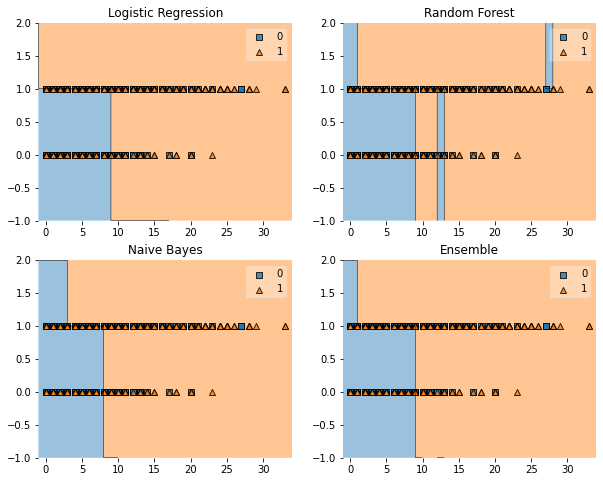

In [15]:
# Dataviz
import matplotlib.pyplot as plt #for custom graphs at the end
import seaborn as sns #for custom graphs at the end

# And plot it
value=1.5
width=0.75
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(10,8))
labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']
for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         labels,
                         itertools.product([0, 1], repeat=2)):
                         
    clf.fit(X_train_ml, y_train_ml)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_ml, y=y_train_ml, clf=clf)
    plt.title(lab)

In [16]:
import sys
sys.path.append('..')

from inxai import *
import shap
import lime

In [17]:
gm = GlobalFeatureMetric()

In [29]:
shap_res = generate_per_instance_importances(models=xgbc, X=X_test, y=y_test, framework='kernel_shap')
shap_res

[array([ 3.02014536e-01,  6.71224127e-02,  2.90870041e-02, -3.01963987e-02,
         5.11021756e-02,  4.85880732e-04,  9.06150352e-03,  1.76172695e-04,
         9.46885988e-04,  1.51681280e-02, -1.92430116e-02]),
 array([ 0.06850452,  0.0536528 , -0.00894848,  0.04073995,  0.00733186,
        -0.00029289,  0.02493507, -0.00027245, -0.00054055, -0.0121101 ,
         0.02580632]),
 array([-1.39492134e-02,  6.05379447e-02, -1.87856453e-02,  5.58407636e-02,
        -1.59093970e-02, -1.01019544e-05,  1.53753202e-03, -3.17782415e-04,
         1.68548950e-03, -9.68570887e-03, -1.42658806e-02]),
 array([ 0.1051713 ,  0.04416073, -0.00745763, -0.17452586,  0.02115242,
        -0.0008709 , -0.0348561 , -0.00026195, -0.00199271, -0.03843859,
         0.02467762]),
 array([ 8.41805897e-02, -1.01716736e-01, -9.76476847e-03, -1.68485896e-02,
         4.29012148e-02, -6.94919578e-05,  1.51597048e-03, -2.81400215e-04,
        -3.41560273e-03,  1.46125066e-01, -1.08582106e-02]),
 array([ 9.52537124e-02

In [28]:
# lime_res = generate_per_instance_importances(models=xgbc, X=X_test, y=y_test, framework='lime')
# lime_res

In [23]:
import pickle

path_to_home_downloads = os.getenv("HOME") + "/Downloads/" 

with open(path_to_home_downloads + "shap_res" + '.pickle', 'wb') as f:
    pickle.dump(shap_res, f)

with open(path_to_home_downloads + "lime_res" + '.pickle', 'wb') as f:
    pickle.dump(lime_res, f)


NameError: name 'lime_res' is not defined

In [19]:
1+1

2